<a href="https://colab.research.google.com/github/sunnysavita10/Complete-LLM-Finetuning/blob/main/Knowledge_DIstillation_in_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step by Step Explain:

Dataset Load:

MNIST (digits 0–9), normalized and made into batches.

Teacher & Student Models:

Both are simple MLP networks.

Teacher has a larger hidden size (512 neurons) → accurate but slow.

Student is smaller (128 neurons) → fast but less capacity.

Teacher Training:

Train the teacher with normal supervised learning using CrossEntropy loss.

Then freeze (don’t train further).

Distillation (Main Step):

For each batch:

Apply softmax with temperature to the teacher’s logits to create soft targets (probability distribution).

Take the student’s output and compute the KL Divergence (teacher vs student) loss.

Also take the normal label loss (CrossEntropy).

Final loss = alpha*soft + (1-alpha)*hard.

Result:

The student is small but keeps high accuracy by copying the teacher’s “knowledge.”

1. transforms.ToTensor()

MNIST images are originally in PIL Image format (28×28 grayscale).

This converts them into a PyTorch Tensor, and also scales pixel values to the [0,1] range.

Originally, pixel values are between 0–255.

After ToTensor(), each pixel becomes pixel / 255.

2. transforms.Normalize((0.5,), (0.5,))
This further shifts and scales pixel values to the [-1, 1] range.

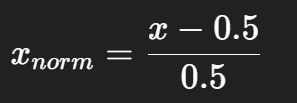
​

where x is the pixel value in [0,1] (after ToTensor()).

Meaning:

0 → -1

0.5 → 0

1 → +1

We normalize like this because:

Neural networks train better when inputs are centered around zero (mean ≈ 0).

It helps speed up training and prevents issues like exploding/vanishing gradients.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
# ----- Dataset (MNIST) -----
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=1000)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.13MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.8MB/s]


In [4]:
import matplotlib.pyplot as plt
images, labels = next(iter(train_loader))

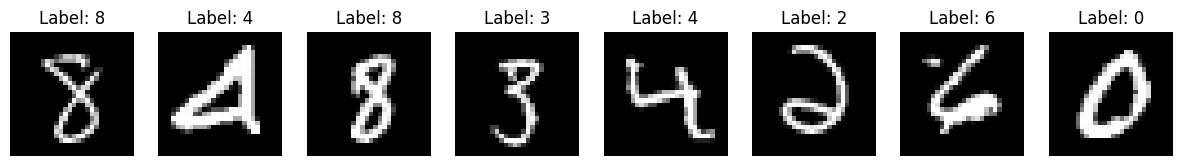

In [5]:
fig, axes = plt.subplots(1, 8, figsize=(15, 2))
for i, ax in enumerate(axes):
    ax.imshow(images[i].squeeze(), cmap='gray')  # grayscale
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')

plt.show()


In [27]:
import torch
import torch.nn as nn

# ----- Teacher Model (2 hidden layers) -----
class TeacherMLP(nn.Module):
    def __init__(self, hidden1=512, hidden2=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, 10)  # 10 output classes (digits)
        )
    def forward(self, x):
        return self.net(x)

In [28]:
# Create instances
teacher = TeacherMLP(hidden1=512, hidden2=256)

In [29]:
print(teacher)

TeacherMLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [30]:
# ----- Train Teacher -----
def train_teacher(model, loader, epochs=1, lr=1e-3):

    opt = optim.Adam(model.parameters(), lr=lr)

    loss_fn = nn.CrossEntropyLoss()

    model.train()

    for ep in range(epochs):
        total_loss = 0
        for x, y in loader:
            opt.zero_grad()
            out = model(x)
            loss = loss_fn(out, y)
            loss.backward()
            opt.step()
            total_loss += loss.item()
        print(f"Teacher Epoch {ep+1}: Loss = {total_loss/len(loader):.4f}")

In [31]:
train_teacher(teacher, train_loader)

Teacher Epoch 1: Loss = 0.3027


In [32]:
print(teacher.state_dict())  # Ye updated weights dikhayega


OrderedDict([('net.1.weight', tensor([[-0.0226,  0.0012, -0.0154,  ..., -0.0175, -0.0362, -0.0267],
        [-0.0119, -0.0141, -0.0230,  ...,  0.0003,  0.0189,  0.0281],
        [ 0.0184,  0.0174, -0.0294,  ...,  0.0196,  0.0083, -0.0079],
        ...,
        [ 0.0385,  0.0217,  0.0104,  ..., -0.0297, -0.0022,  0.0197],
        [-0.0067, -0.0302, -0.0067,  ..., -0.0211, -0.0273, -0.0380],
        [-0.0181, -0.0165, -0.0014,  ...,  0.0462,  0.0410, -0.0159]])), ('net.1.bias', tensor([ 0.0327,  0.0078,  0.0153,  0.0101, -0.0207,  0.0004, -0.0036, -0.0052,
        -0.0372, -0.0105, -0.0349, -0.0190, -0.0225,  0.0172,  0.0063, -0.0016,
        -0.0292, -0.0367,  0.0319,  0.0065, -0.0353, -0.0167, -0.0175, -0.0036,
        -0.0350, -0.0036, -0.0281,  0.0069,  0.0109,  0.0164, -0.0116,  0.0093,
         0.0014, -0.0309,  0.0250, -0.0049, -0.0204, -0.0078,  0.0299, -0.0253,
        -0.0145,  0.0215, -0.0091,  0.0277, -0.0342, -0.0293, -0.0042,  0.0091,
         0.0270,  0.0273, -0.0002, -0.0

In [ ]:
# # ----- Freeze Teacher -----
# for param in teacher.parameters():
#     param.requires_grad = False
# teacher.eval()
# print("Teacher model trained and frozen.")

In [33]:
# ----- Student Model (1 hidden layer) -----
class StudentMLP(nn.Module):
    def __init__(self, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 10)  # smaller model, only 1 hidden layer
        )
    def forward(self, x):
        return self.net(x)

In [34]:
student = StudentMLP(hidden=128)

In [35]:
print(student)

StudentMLP(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [36]:
# (A) Pretrain student on hard labels (optional warm-up)
def pretrain_student(student, loader, epochs=1, lr=1e-3):
    student.train()
    opt = optim.Adam(student.parameters(), lr=lr)
    ce_loss = nn.CrossEntropyLoss()
    for ep in range(epochs):
        for x, y in loader:
            opt.zero_grad()
            out = student(x)
            loss = ce_loss(out, y)
            loss.backward()
            opt.step()

In [37]:
pretrain_student(student, train_loader, epochs=1)  # optional warm-up

In [38]:
# ----- Distillation Training -----
temperature = 2.0
alpha = 0.7
ce_loss = nn.CrossEntropyLoss()
kl_loss = nn.KLDivLoss(reduction="batchmean")
optimizer = optim.Adam(student.parameters(), lr=1e-3)

In [39]:
def distill(student, teacher, loader, epochs=1):
    for ep in range(epochs):

        student.train()

        total_loss = 0

        for x, y in loader:
            # Teacher outputs
            with torch.no_grad():
                t_logits = teacher(x)
                t_probs = torch.softmax(t_logits / temperature, dim=1)

            # Student outputs
            s_logits = student(x)
            s_log_probs = torch.log_softmax(s_logits / temperature, dim=1)

            # Losses
            loss_soft = kl_loss(s_log_probs, t_probs) * (temperature**2)
            loss_hard = ce_loss(s_logits, y)
            loss = alpha * loss_soft + (1 - alpha) * loss_hard

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            total_loss += loss.item()
        print(f"Student Epoch {ep+1}: Loss = {total_loss/len(loader):.4f}")

In [ ]:
# # (B) Then run your existing distill(...)
# distill(student, teacher, train_loader, epochs=3)

In [40]:
distill(student, teacher, train_loader)

Student Epoch 1: Loss = 0.1682


In [41]:
# ----- 5. Evaluation Function -----
def evaluate(model, loader, name="Model"):
    model.eval()

    correct, total = 0, 0

    with torch.no_grad():
        for x, y in loader:
            out = model(x)
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = correct / total * 100
    print(f"{name} Accuracy: {acc:.2f}%")
    return acc

In [42]:
# Evaluate both Teacher and Student
evaluate(teacher, test_loader, "Teacher")

Teacher Accuracy: 94.20%


94.19999999999999

In [43]:
evaluate(student, test_loader, "Student")

Student Accuracy: 94.21%


94.21000000000001

In [21]:
# ----- 6. Sample Predictions -----
def predict(model, x):
    model.eval()
    with torch.no_grad():
        out = model(x)
        return out.argmax(dim=1)

In [22]:
sample_batch, sample_labels = next(iter(test_loader))

In [23]:
preds = predict(student, sample_batch)

In [24]:
print("Sample predictions (Student):", preds[:20])

Sample predictions (Student): tensor([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])


In [25]:
print("True labels:", sample_labels[:20])

True labels: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4])


In [26]:
# ----- 7. Save Student Model -----
torch.save(student.state_dict(), "distilled_student.pth")
print("Student model saved as distilled_student.pth")

Student model saved as distilled_student.pth


### With Classical LM (Bert)


| Block                   | Purpose (Hindi explain)                                                                                                    |
| ----------------------- | -------------------------------------------------------------------------------------------------------------------------- |
| **0. Imports & config** | Sab library, GPU detect, hyperparameters set.                                                                              |
| **1. Dataset**          | Demo dataset load + tokenization; collator pad karega.                                                                     |
| **2. Models**           | BERT teacher load (freeze), DistilBERT student load (trainable).                                                           |
| **3. Losses**           | CE (hard) + KL (soft); temperature se softmax blur.                                                                        |
| **4. Optimizer**        | AdamW + linear LR schedule.                                                                                                |
| **5. distill\_epoch()** | Har batch: <br>• Teacher logits → soft targets <br>• Student logits <br>• Loss combine (α) <br>• Backprop only on student. |
| **evaluate()**          | Validation accuracy check.                                                                                                 |
| **Loop**                | epochs ke liye train + eval.                                                                                               |
| **Save**                | Fine‑tuned student ko disk pe dump kar diya.                                                                               |


Tip: For large datasets and running on multiple GPUs/TPUs, you can use the Trainer’s DistillationTrainer wrapper or Accelerate—the core logic stays the same.

Here’s what’s happening step by step:

Teacher Output (t_soft)

We take the teacher’s (larger model’s) output logits.

We use a temperature (T = 2.0) to smooth the softmax—this means the teacher doesn’t just say “this is class 1,” but provides a probability distribution (e.g., 0.6, 0.3, 0.1).

Student Output (s_soft)

The student model also produces logits for the same input.

We compute the log-softmax so we can calculate the KL Divergence.

Distillation Loss (loss_soft)

KLDivLoss measures how different the student’s probability distribution is from the teacher’s soft distribution.

We multiply by temperature² to adjust the scale (Hinton paper’s rule).

Final Loss

loss = alpha_soft * loss_soft + (1 - alpha_soft) * loss_hard

Meaning the student learns from both:

The teacher’s knowledge (soft targets).

The dataset’s true labels (hard targets).

This teacher–student training is knowledge distillation. If we only used loss_hard, it would be normal fine-tuning, not distillation.

In [1]:
!pip install --upgrade datasets fsspec transformers

  Using cached fsspec-2025.7.0-py3-none-any.whl.metadata (12 kB)


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from torch.utils.data import DataLoader

In [4]:
batch_size   = 16
lr           = 5e-5
epochs       = 1
temperature  = 2.0
alpha_soft   = 0.5
max_len      = 128
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Load dataset
raw = load_dataset("tweet_eval", "sentiment")

In [6]:
label_feature = raw["train"].features["label"]

In [7]:
print("Label names:", label_feature.names)

Label names: ['negative', 'neutral', 'positive']


In [8]:
# Subset (2.5k samples for train)
train = raw['train'].shuffle(seed=42).select(range(2500))

Why Train is Subset, but Val is Not

🔹 1. Training cost is high, validation cost is low

Training = multiple forward + backward passes → GPU heavy

Validation = only forward pass, no gradient update → fast

So it’s common to reduce training size for quick experiments but keep full validation for accurate metric evaluation.

🔹 2. Keeping val full improves generalization check

If you also reduce validation (e.g., from 872 → 100), metrics become noisy and unreliable.

Full validation gives stable accuracy/loss during training.

In [9]:
val   = raw['validation']

In [10]:
#Tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [11]:
def tokenize(example):
    return tokenizer(example["text"], truncation=True, max_length=max_len)

In [12]:
# Tokenize & remove original text column
tokenized = {}

In [13]:
tokenized['train'] = train.map(tokenize, batched=True, remove_columns=['text'])
tokenized['validation'] = val.map(tokenize, batched=True, remove_columns=['text'])

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [14]:
# Data Collator (auto-padding)
collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)

In [15]:
# DataLoaders
train_dl = DataLoader(tokenized['train'], batch_size=batch_size,shuffle=True, collate_fn=collator)

In [16]:
val_dl = DataLoader(tokenized['validation'], batch_size=batch_size,shuffle=False, collate_fn=collator)

In [17]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [18]:
num_labels = 3

In [19]:
teacher = AutoModelForSequenceClassification.from_pretrained(
    "bert-large-uncased", num_labels=num_labels).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
student = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=num_labels).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Freeze teacher (no training)
for p in teacher.parameters():
    p.requires_grad = False
teacher.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1

In [22]:
ce_loss = nn.CrossEntropyLoss()

In [23]:
kl_loss = nn.KLDivLoss(reduction="batchmean")

In [24]:
optimizer = optim.AdamW(student.parameters(), lr=lr)

In [25]:
from transformers import get_scheduler

In [26]:
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dl) * epochs,
)

In [27]:
from tqdm.auto import tqdm

In [28]:
def distill_epoch():
    student.train()
    pbar = tqdm(train_dl, desc="Train")
    for batch in pbar:
        input_ids = batch["input_ids"].to(device)
        attention = batch["attention_mask"].to(device)
        labels    = batch["labels"].to(device)

        # Teacher predictions (soft targets)
        with torch.no_grad():
            t_logits = teacher(input_ids, attention_mask=attention).logits
            t_soft   = torch.softmax(t_logits / temperature, dim=1)

        # Student predictions
        s_logits = student(input_ids, attention_mask=attention).logits
        s_soft   = torch.log_softmax(s_logits / temperature, dim=1)

        # Distillation + CE Loss
        loss_soft = kl_loss(s_soft, t_soft) * (temperature ** 2)
        loss_hard = ce_loss(s_logits, labels)
        loss      = alpha_soft * loss_soft + (1 - alpha_soft) * loss_hard

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})

In [29]:
def evaluate():
    student.eval()
    correct = total = 0
    with torch.no_grad():
        for batch in val_dl:
            ids  = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            lbl  = batch["labels"].to(device)
            out  = student(ids, attention_mask=attn).logits
            pred = out.argmax(dim=1)
            correct += (pred == lbl).sum().item()
            total   += lbl.size(0)
    return round(correct / total * 100, 2)

In [30]:
for ep in range(1, epochs + 1):
    distill_epoch()
    acc = evaluate()
    print(f"Epoch {ep}/{epochs} | Validation Accuracy: {acc}%")

Train:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/1 | Validation Accuracy: 62.7%


In [31]:
# ---------- 6. Save Student ----------
student.save_pretrained("distilled_student_model")
tokenizer.save_pretrained("distilled_student_model")

('distilled_student_model/tokenizer_config.json',
 'distilled_student_model/special_tokens_map.json',
 'distilled_student_model/vocab.txt',
 'distilled_student_model/added_tokens.json',
 'distilled_student_model/tokenizer.json')

In [32]:
from sklearn.metrics import accuracy_score
import time

def predict_and_evaluate(model, name, test_dl):
    model.eval()
    all_preds, all_labels = [], []
    start_time = time.time()

    with torch.no_grad():
        for batch in test_dl:
            ids = batch["input_ids"].to(device)
            attn = batch["attention_mask"].to(device)
            lbls = batch["labels"].to(device)

            logits = model(ids, attention_mask=attn).logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(lbls.cpu().tolist())

    total_time = time.time() - start_time
    acc = accuracy_score(all_labels, all_preds)
    avg_time = total_time / len(test_dl.dataset)

    print(f"\n {name}")
    print(f" Accuracy: {acc*100:.2f}%")
    print(f" Total Inference Time: {total_time:.2f} sec")
    print(f" Avg Time per Sample: {avg_time:.4f} sec")
    return acc, total_time, avg_time

In [33]:
# --------- Load test set ---------
test = load_dataset("tweet_eval", "sentiment", split="test[:500]")  # sample test
tokenized_test = test.map(tokenize, batched=True, remove_columns=["text"])
tokenized_test.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dl = DataLoader(tokenized_test, batch_size=batch_size, shuffle=False, collate_fn=collator)

In [34]:
# --------- Compare Teacher vs Student ---------
predict_and_evaluate(teacher, name="TEACHER (BERT-Large)", test_dl=test_dl)
predict_and_evaluate(student, name="STUDENT (Distilled BERT)", test_dl=test_dl)



 TEACHER (BERT-Large)
 Accuracy: 22.00%
 Total Inference Time: 3.63 sec
 Avg Time per Sample: 0.0073 sec

 STUDENT (Distilled BERT)
 Accuracy: 60.80%
 Total Inference Time: 1.16 sec
 Avg Time per Sample: 0.0023 sec


(0.608, 1.1580901145935059, 0.0023161802291870115)

Backed by Research

📄 “Distilling Step-by-Step” (Google, ACL 2023)

A 770M T5 student outperformed PaLM-540B teacher on multiple tasks using rationale distillation.

📄 TinyBERT paper (Huawei, 2020)

Task-specific distillation allowed TinyBERT to beat BERT-base on SST-2 and MNLI.

| Reason                               | Explanation                                                            |
| ------------------------------------ | ---------------------------------------------------------------------- |
| **TweetEval = small, noisy data** | BERT-Large is overfitting or underconfident due to task size           |
| **Student is fine-tuned**         | You updated student weights on TweetEval task                          |
| **Teacher is frozen**             | You're using teacher just for soft logits, not re-finetuning           |
| **Teacher not task-specific**     | Your BERT-Large is general, but student is task-tuned via distillation |


| Model   | Accuracy | Speed | Comment                                                 |
| ------- | -------- | ----- | ------------------------------------------------------- |
| Teacher | 22%      | Slow  | Not tuned, generic, likely overfitting/underfitting     |
| Student | 60.8%    | Fast  | Task-specific distilled, learned from soft+hard targets |


## With LLM


Teacher (LLaMA‑2 7B) produces a probability distribution (next‑token probabilities) for each prompt.

Student (TinyLLaMA 1.1B) is trained to:

Mimic the teacher’s distribution (KLDivLoss → soft targets).

Be correct on the ground‑truth labels (CrossEntropyLoss → hard targets).

During each prompt, backpropagation updates only the Student’s weights.

As a result, the Student copies the Teacher’s reasoning behavior while being smaller and faster.

How is it run in practice?

The given snippet is just a mini example (3 prompts).

In real distillation:

Use millions of prompts (including synthetic ones).

Train in batches with Accelerate/DeepSpeed to manage GPU memory.

Precompute and store teacher outputs offline, then train the Student on those for a faster pipeline.

#### teacher_id = "meta-llama/Llama-2-7b-chat-hf"      # big model (teacher)
#### student_id = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"  # small model (student)

#### teacher_id = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
#### student_id = "TinyLlama/TinyLlama-1.1B-intermediate-step-1431k-3T"

In [21]:
!pip install transformers accelerate bitsandbytes

In [22]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import torch.nn as nn
import torch.optim as optim

In [23]:
teacher_id = "microsoft/phi-2"
student_id = "microsoft/phi-1_5"

In [24]:
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_id)
student_tokenizer = AutoTokenizer.from_pretrained(student_id)

In [25]:
if teacher_tokenizer.pad_token is None:
    teacher_tokenizer.pad_token = teacher_tokenizer.eos_token
if student_tokenizer.pad_token is None:
    student_tokenizer.pad_token = student_tokenizer.eos_token

In [26]:
teacher = AutoModelForCausalLM.from_pretrained(
    teacher_id,
    device_map="auto",
    load_in_8bit=True,
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
for p in teacher.parameters():
    print(p)

Parameter containing:
tensor([[ 1.6998e-02, -1.3275e-02,  2.0309e-02,  ...,  1.7822e-02,
          5.1346e-03, -7.7343e-04],
        [ 9.7351e-03,  5.1636e-02,  1.5656e-02,  ..., -6.7329e-03,
          6.9389e-03, -1.1322e-02],
        [-4.6387e-02, -9.0942e-03, -1.1349e-03,  ..., -3.0945e-02,
          3.8940e-02,  1.3847e-02],
        ...,
        [-5.9605e-08,  5.9605e-08, -5.9605e-08,  ...,  1.5140e-05,
         -1.1206e-05,  1.7762e-05],
        [-0.0000e+00, -5.9605e-08, -1.1921e-07,  ..., -2.5094e-05,
          3.7730e-05,  2.0683e-05],
        [ 0.0000e+00, -5.9605e-08,  5.9605e-08,  ..., -1.6034e-05,
         -1.5676e-05, -3.5882e-05]], device='cuda:0', dtype=torch.float16,
       requires_grad=True)
Parameter containing:
Parameter(Int8Params([[ 26,  -5, -23,  ..., -30,  15,  11],
            [-37, -16, -10,  ...,  15,   0, -26],
            [-22, -11,  -4,  ...,   0,   9,   9],
            ...,
            [-35, -26,   5,  ...,  20,  12,  34],
            [-37,  50,  -2,  ...

In [28]:
teacher.eval()
for p in teacher.parameters():
    p.requires_grad = False

In [29]:
student = AutoModelForCausalLM.from_pretrained(
    student_id,
    device_map="auto",
    load_in_8bit=True,
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


In [30]:
prompts = [
    "Explain why the sky is blue. ### The sky appears blue because molecules in Earth's atmosphere scatter sunlight, and blue light is scattered more than other colors due to its shorter wavelength.",
    "What is the capital of France? ### The capital of France is Paris.",
    "Write a short story about a robot and a cat. ### Once upon a time, a lonely robot found a stray cat. They became best friends, exploring the city together, and the robot learned the meaning of companionship."
]


In [31]:
# ----- Distillation Hyperparams -----
temperature = 2.0
alpha_soft  = 0.7
ce_loss     = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
kl_loss     = nn.KLDivLoss(reduction="batchmean")
optimizer   = optim.AdamW(student.parameters(), lr=2e-5)

In [33]:
for prompt in prompts:
    # --- Tokenize separately ---
    t_inputs = teacher_tokenizer(prompt, return_tensors="pt", padding=True).to(teacher.device)
    s_inputs = student_tokenizer(prompt, return_tensors="pt", padding=True).to(student.device)

    with torch.no_grad():
        t_logits = teacher(**t_inputs).logits[:, :-1, :]
        t_soft = torch.softmax(t_logits / temperature, dim=-1)
        t_soft = torch.clamp(t_soft, min=1e-8)  # 🛠️ avoid log(0) in KLDiv

    s_logits = student(**s_inputs).logits[:, :-1, :]
    s_log_soft = torch.log_softmax(s_logits / temperature, dim=-1)

    labels = s_inputs["input_ids"][:, 1:].contiguous()

    loss_hard = ce_loss(s_logits.reshape(-1, s_logits.size(-1)), labels.reshape(-1))
    loss_soft = kl_loss(s_log_soft, t_soft) * (temperature ** 2)

    loss = alpha_soft * loss_soft + (1 - alpha_soft) * loss_hard

    if torch.isnan(loss):
        print("⚠️ NaN detected on prompt:", prompt[:50])
        continue  # skip to next prompt

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Prompt: {prompt[:40]}..., Loss: {loss.item():.4f}")

Prompt: Explain why the sky is blue. ### The sky..., Loss: nan
Prompt: What is the capital of France? ### The c..., Loss: nan
Prompt: Write a short story about a robot and a ..., Loss: nan


In [ ]:
student.save_pretrained("distilled_phi1_5")
student_tokenizer.save_pretrained("distilled_phi1_5")
print("Distillation complete. Model saved in 'distilled_phi1_5/'")